# 0.0 Imports

In [1]:
import inflection
import math
import datetime

import numpy             as np
import scipy.stats       as ss
import seaborn           as sns
import matplotlib.pyplot as plt
import pandas            as pd

from tabulate              import tabulate
from IPython.display       import Image
from matplotlib.gridspec   import GridSpec
from boruta                import BorutaPy
from IPython.core.display  import display, HTML
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


## 0.1 Helper Functions

In [2]:
# Cramer's V
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values # contingency table
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(observed=cm)[0] # Chi-square test of independence of variables in a contingency table
    chi2_correction = max(0, chi2 - (k-1)*(r-1)/(n-1))
    k_correction = k - ((k-1)**2)/(n-1)
    r_correction = r - ((r-1)**2)/(n-1)
    
    return (np.sqrt((chi2_correction/n) / (min(k_correction-1, r_correction-1))))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML("<style>.container { width:100% !important; }</style>"))
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [3]:
jupyter_settings()


Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on='Store')

In [5]:
df1 = df_raw.copy()

# 1.0 DATA DESCRIPTION

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fill out NA

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x:200000 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov',12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change data types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistics

In [14]:
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])
categorical_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [15]:
#Central tendencies - mean median
ct1 = pd.DataFrame(numerical_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(numerical_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
dispersion1 = pd.DataFrame(numerical_attributes.apply(np.std)).T
dispersion2 = pd.DataFrame(numerical_attributes.apply(min)).T
dispersion3 = pd.DataFrame(numerical_attributes.apply(max)).T
dispersion4 = pd.DataFrame(numerical_attributes.apply(lambda x: x.max()-x.min())).T
dispersion5 = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
dispersion6 = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

#concatening
m = pd.concat([dispersion2,dispersion3,dispersion4, ct1, ct2, dispersion1, dispersion5, dispersion6]).T.reset_index()
m.columns = ['attribute', 'min','max', 'range','mean', 'median','std', 'skew','kurtosis']
m

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


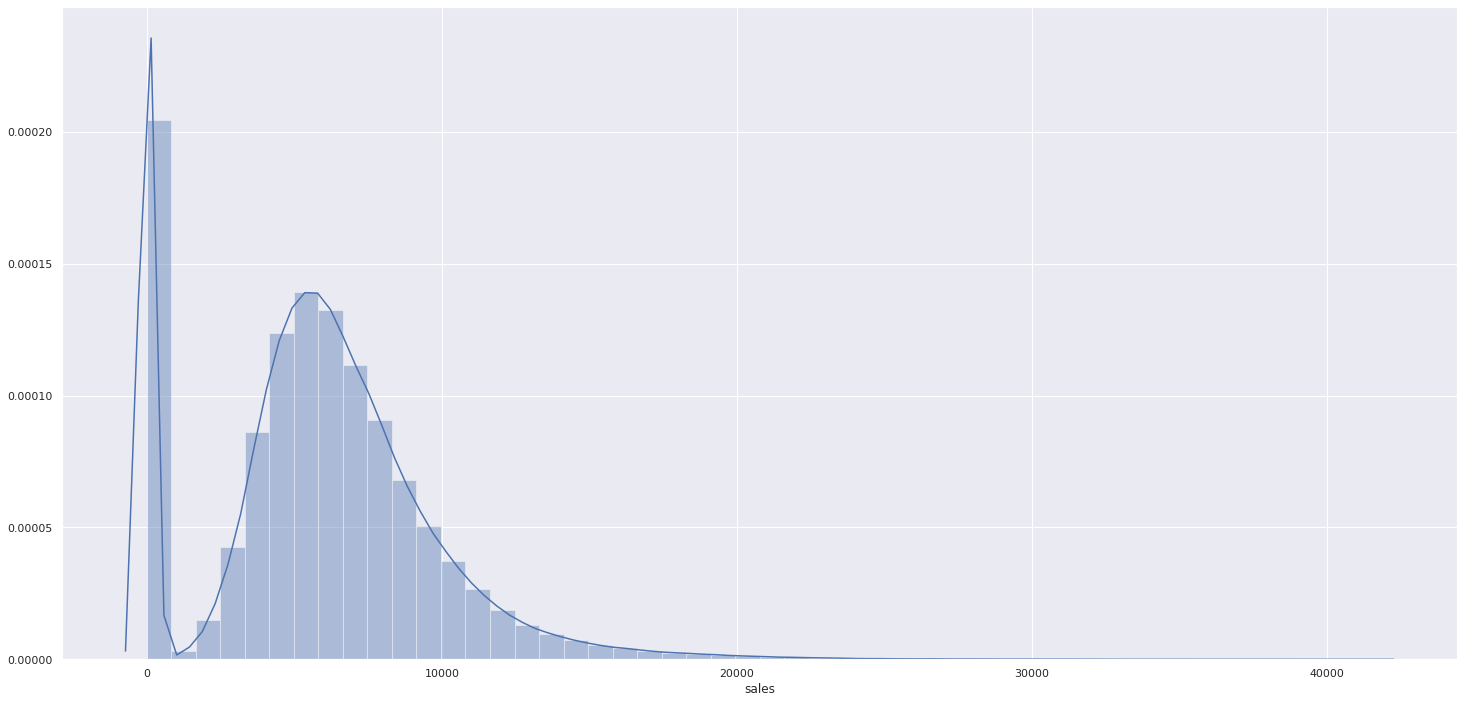

In [16]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical Attributes

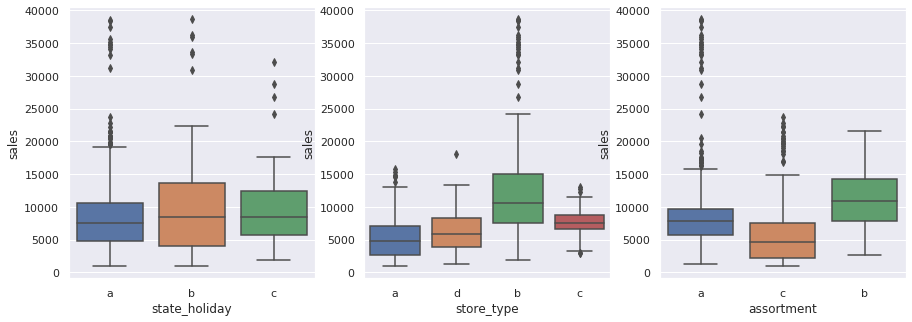

In [17]:
plt.rcParams['figure.figsize'] = [15, 5]

aux1 = df1[(df1['sales'] > 0) & (df1['state_holiday'] != '0')]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 FEATURE ENGINEERING

## 2.1 Hypothesis mind map

In [18]:
df2 = df1.copy()

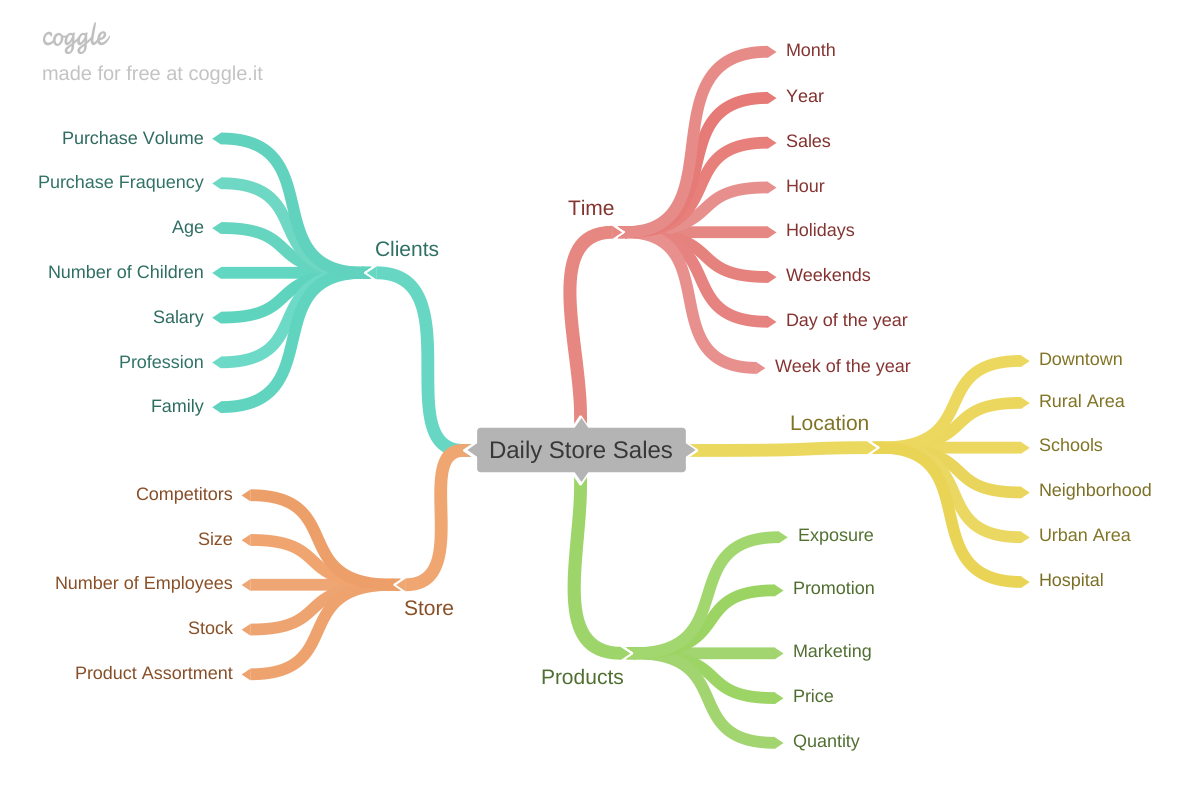

In [19]:
Image('img/MindMapHypothesis.png')

## 2.2 Hypothesis creation

### 2.1.1 Store Hypothesis

**1.** Stores with more employees sell more.

**2.** Stores with bigger stocks sell more.

**3.** Bigger stores sell more.

**4.** More product assorted stores sell more 

### 2.1.2 Product Hypothesis

**1.** Stores that invest more in marketing sell more.

**2.** Stores that display their products on shop windows sell more.

**3.** Stores with lower prices sell more.

**4.** Stores with lower prices for longer periods sell more 

### 2.1.3 Temporal Hypothesis

**1.** Stores that close on holidays sell less.

**2.** Stores opening in the first six months sell more.

**3.** Stores that open on weekends sell more.

## 2.3 Final Hypothesis

**1.** More product assorted stores sell more

**2.** Stores with competition nearby sell less

**3.** Stores with long time competition sell more

**4.** Stores on sales for longer sell more 

**5.** Stores with more days on sales sell more

**6.** Stores that are on sales more often sell more

**7.** Stores open on Christmas holidays sell more

**8.** Stores sell more with the years

**9.** Stores sell more during the second semester of the year

**10.** Stores sell more after the 10th day of each month

**11.** Stores sell less during the weekends than on weekdays

**12.** Stores sell less during the scholar holidays

## 2.4 Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime("%Y-%W")
# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christmas' if x =='c' else 'regular_day')

# 3.0 FILTERING VARIABLES

In [21]:
df3 = df2.copy()

In [22]:
df3.sample(3)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
7450,761,6,2015-07-25,6329,633,1,0,regular_day,0,a,basic,2390.0,9,2012,0,30,2015,0,Jul,0,2015,7,25,30,2015-29,2012-09-01,35,2015-07-20,0
10223,189,3,2015-07-22,7530,754,1,0,regular_day,0,d,basic,5760.0,7,2014,0,30,2015,0,Jul,0,2015,7,22,30,2015-29,2014-07-01,12,2015-07-20,0
361774,124,2,2014-08-19,5276,636,1,1,regular_day,1,a,basic,1410.0,4,2003,0,34,2014,0,Aug,0,2014,8,19,34,2014-33,2003-04-01,138,2014-08-18,0


## 3.1 Rows Filtering

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0  EXPLORATORY DATA ANALYSIS

In [25]:
df4 = df3.copy()

## 4.1 Univariate analysis

### 4.1.1 Response variable

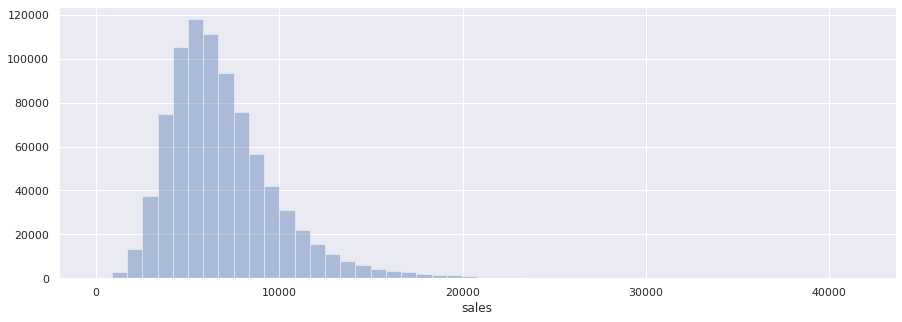

In [26]:
sns.distplot(df4['sales'], kde=False);

### 4.1.2 Numerical variable

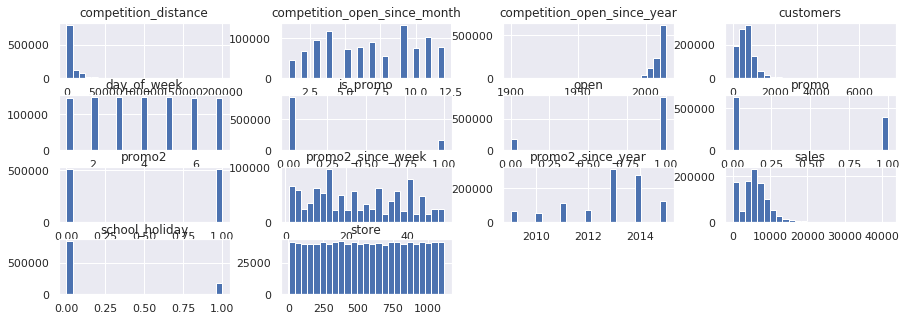

In [27]:
numerical_attributes.hist(bins=25);

### 4.1.3 Categorical variable

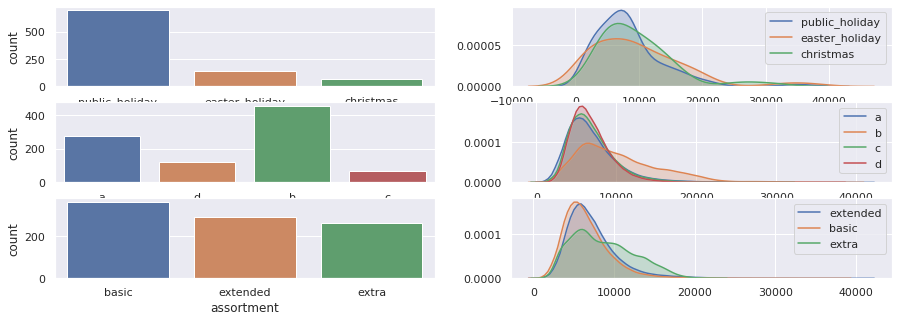

In [28]:
# state holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label ='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label ='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label ='christmas', shade=True)

# Store type
plt.subplot(3,2,3)
sns.countplot(a['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label ='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label ='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label ='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label ='d', shade=True)

# Assortment
plt.subplot(3,2,5)
sns.countplot(a['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label ='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label ='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label ='extra', shade=True)

## 4.2 Bivariate analysis

#### H1. More product assorted stores sell more


**False**. More assorted stores sell less.

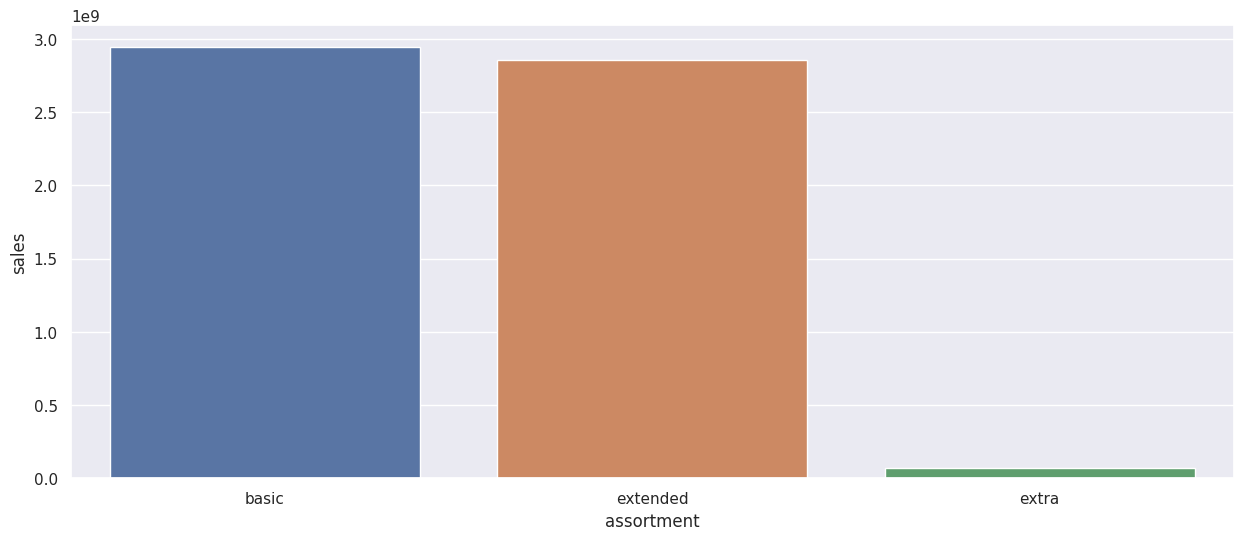

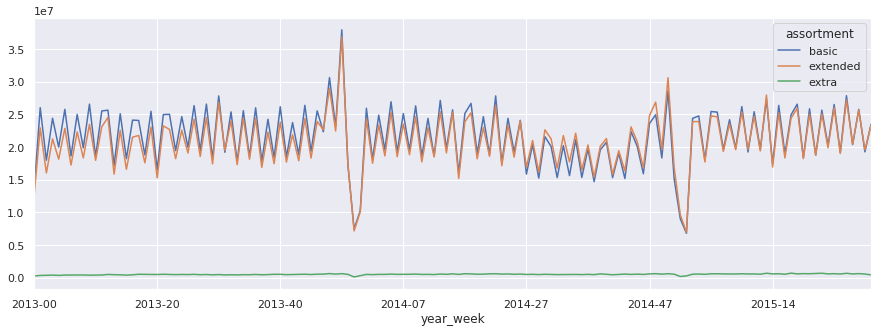

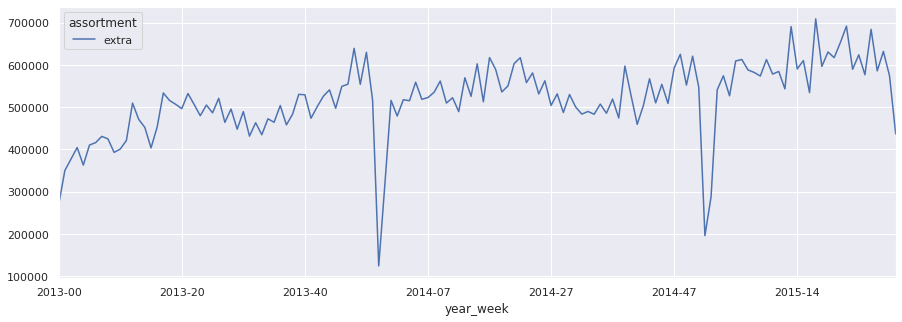

In [29]:
fig=plt.figure(figsize=(15,6), dpi= 100)

aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)


aux2 = df4[['year_week', 'assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()


# Checking if sales in stores with extra assortment behave linearly
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

#### H2. Stores with competition nearby sell less

**False**. Surprisely, stores with competition nearby sell more.

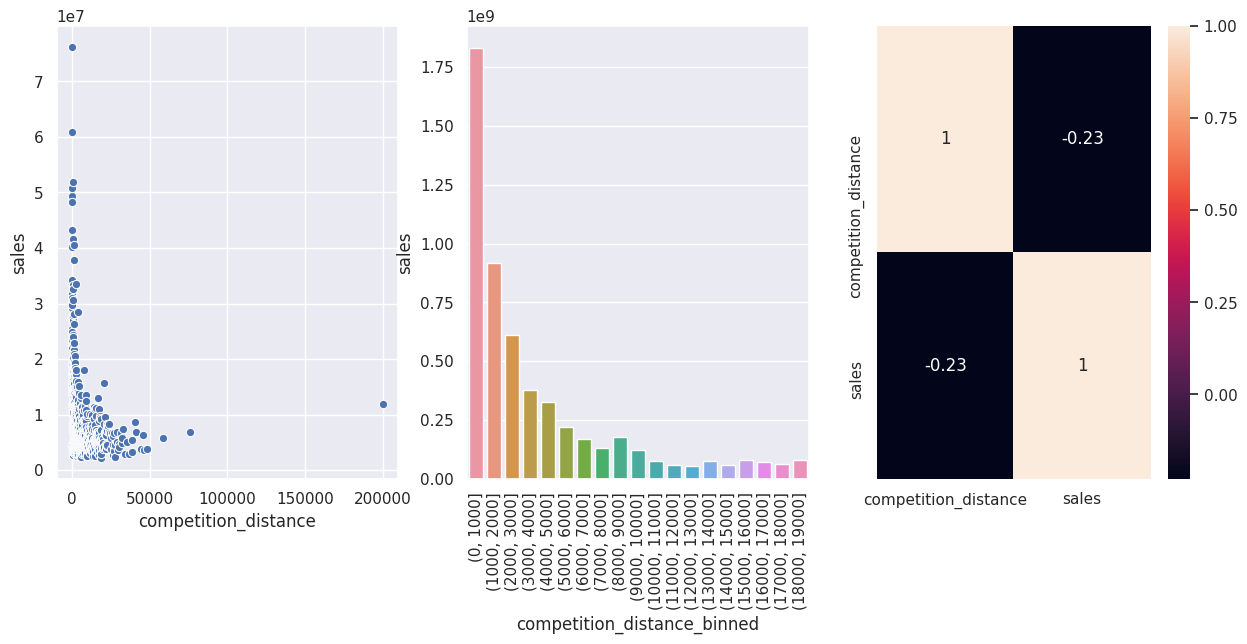

In [30]:
fig=plt.figure(figsize=(15,6), dpi= 100)

plt.subplot(1,3,1)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20_000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H3. Stores with long time competition sell more

**False**. Stores with long time competitors sell less.

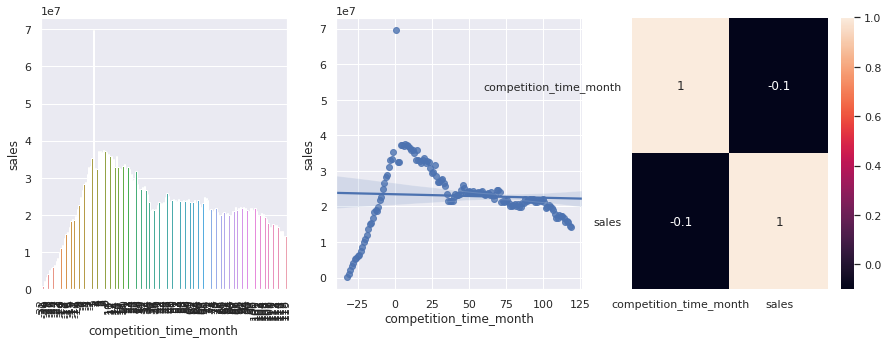

In [31]:
#fig=plt.figure(figsize=(15,6), dpi= 100)

plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(data=aux2, x='competition_time_month', y='sales' )
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(data=aux2, x='competition_time_month', y='sales' );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Stores on sales for longer sell more


**False**. After a certain period on promo, the number of sales starts to drop.

In [32]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

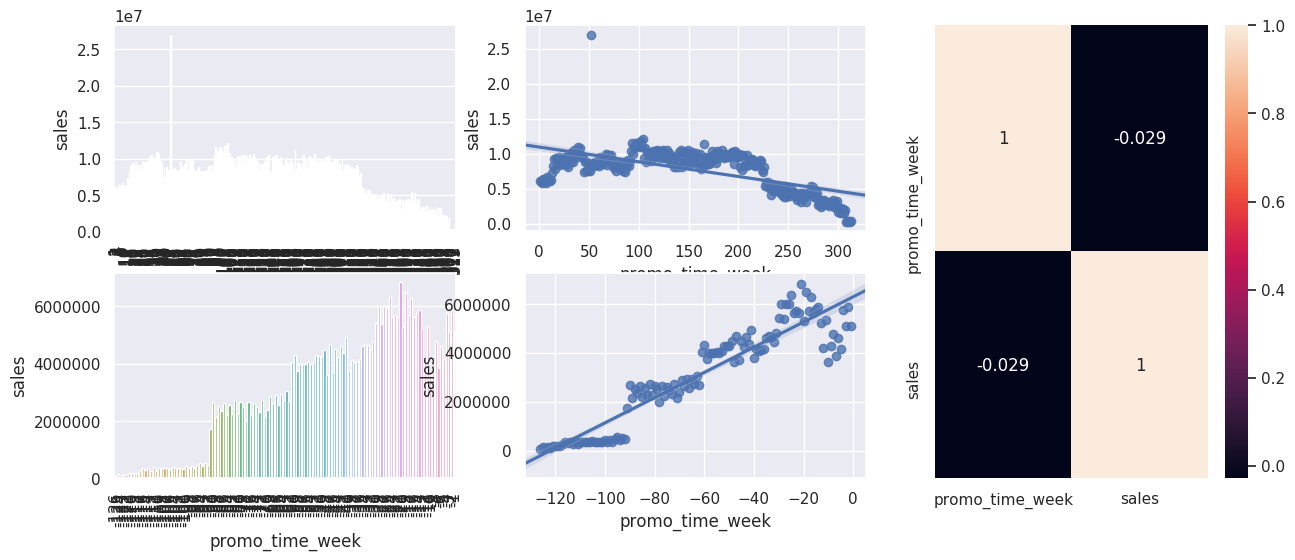

In [33]:
fig=plt.figure(figsize=(15,6), dpi= 100)

grid = GridSpec(2,3)

# promo extended
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

# regular promo
plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

# heatmap
plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H5. Stores with more days on sales sell more

### H6. Stores that are on sales more often sell more

**False.** Stores with more consecutive promos sell less

In [34]:
df4[['sales','promo','promo2']].groupby(['promo','promo2']).sum().sort_values(by='sales', ascending=False).reset_index()

,promo,promo2,sales
0,1,0,1628930532
1,0,0,1482612096
2,1,1,1472275754
3,0,1,1289362241


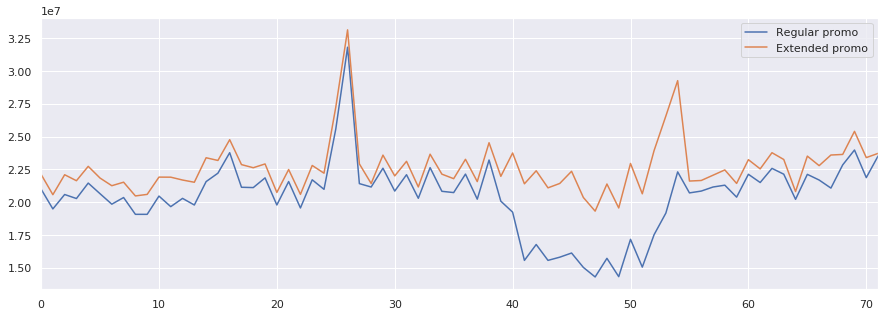

In [35]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax);

ax.legend(['Regular promo', 'Extended promo']);

### H7. Stores open on Christmas holidays sell more

**False**. Stores opened on Christmas holiday sell less

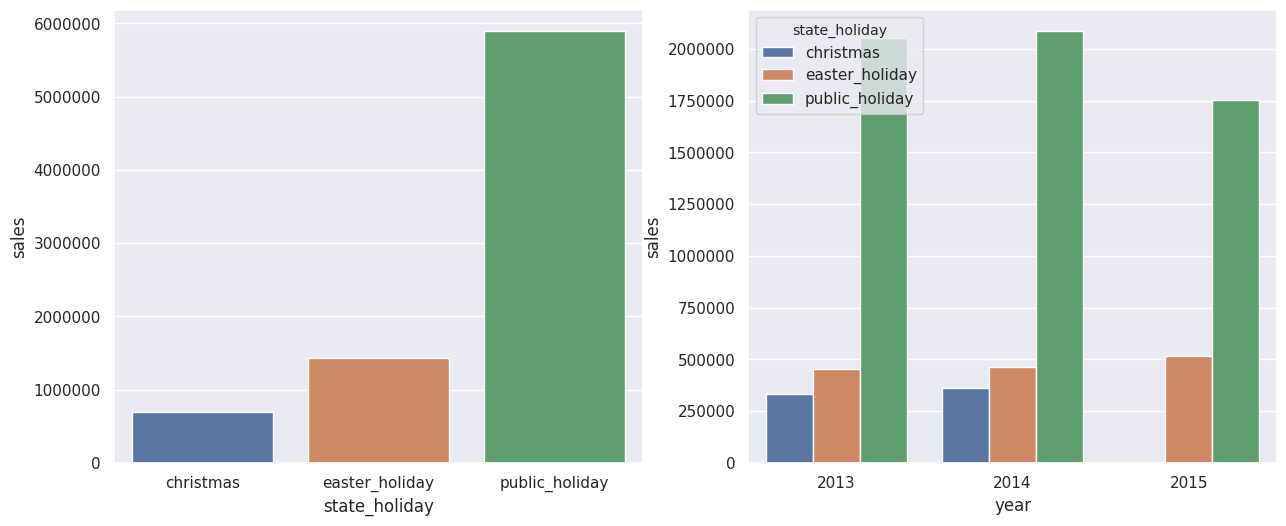

In [36]:
fig=plt.figure(figsize=(15,6), dpi= 100)

plt.subplot(1,2,1)
aux1 = df4[df4['state_holiday'] != 'regular_day'][['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = df4[df4['state_holiday'] != 'regular_day'][['year', 'state_holiday', 'sales']].groupby(['state_holiday','year']).sum().reset_index()
sns.barplot(x='year', y='sales', hue = 'state_holiday', data=aux2);

### H8. Stores sell more with the years


**False**. Although 2015 haven't finished yet, stores are selling less with the years.

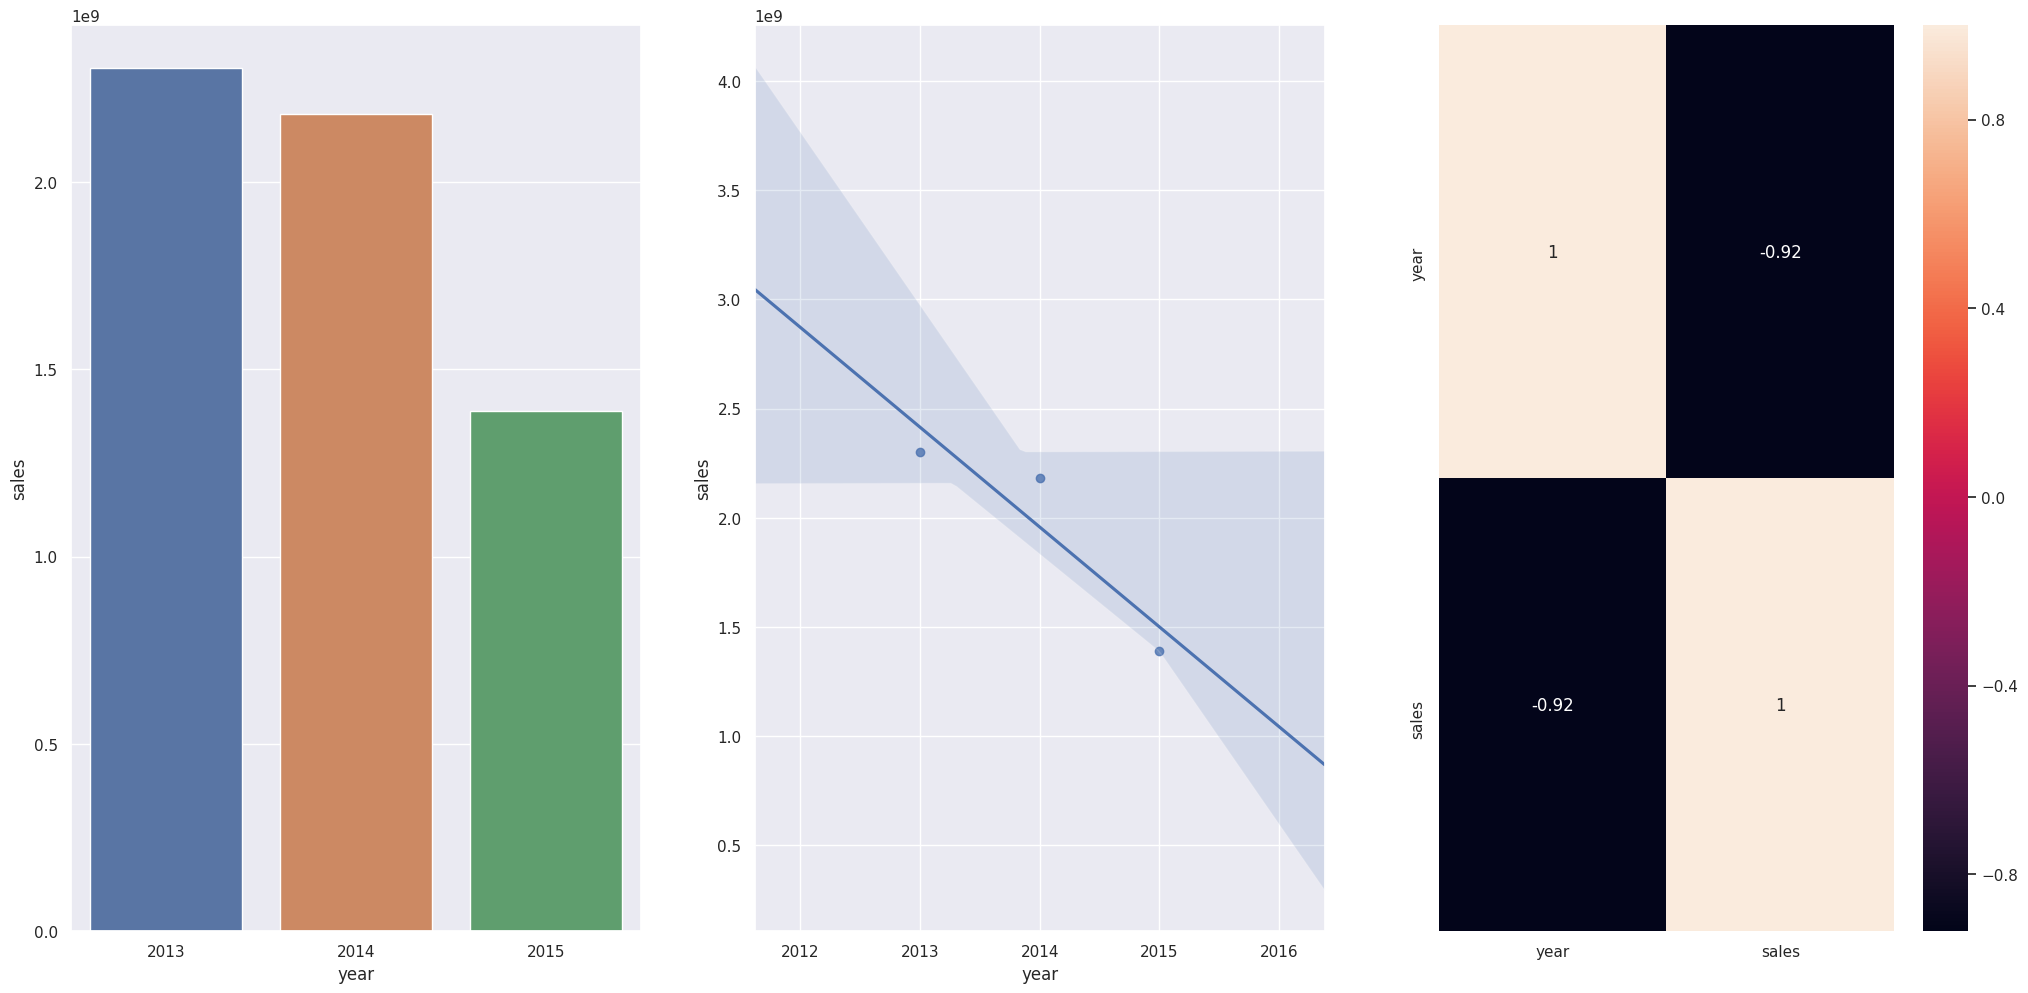

In [37]:
fig=plt.figure(figsize=(25,12), dpi= 100)

plt.subplot(1,3,1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9. Stores sell more during the second semester of the year

**False**. Stores sell less during the second semester.

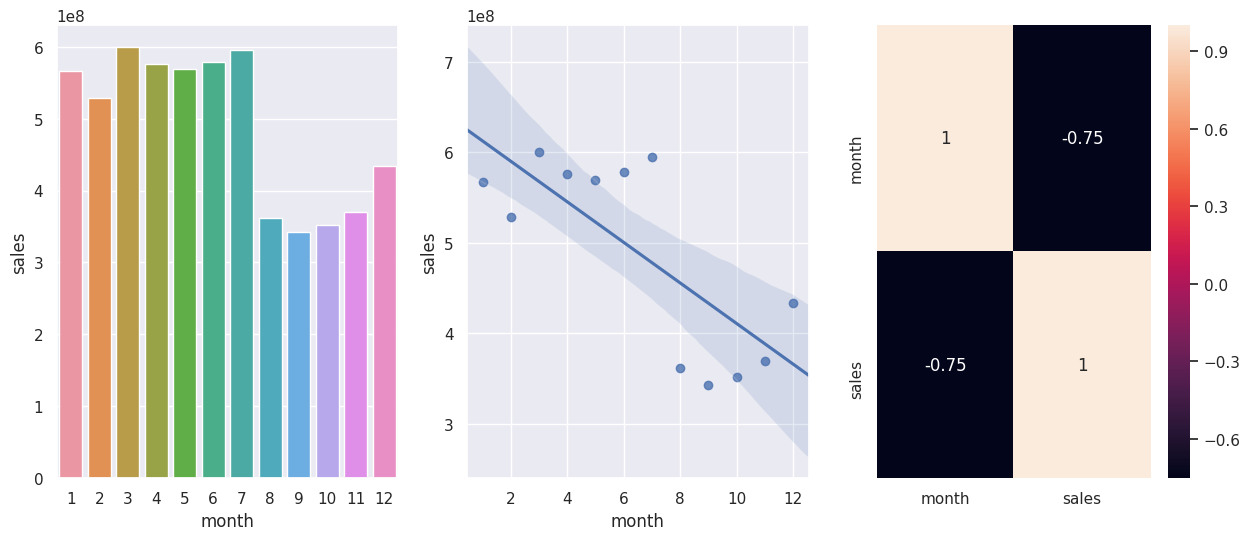

In [38]:
fig=plt.figure(figsize=(15,6), dpi= 100)

plt.subplot(1,3,1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Stores sell more after the 10th day of each month

**True**. Sales volume is greater after 10th day of the month

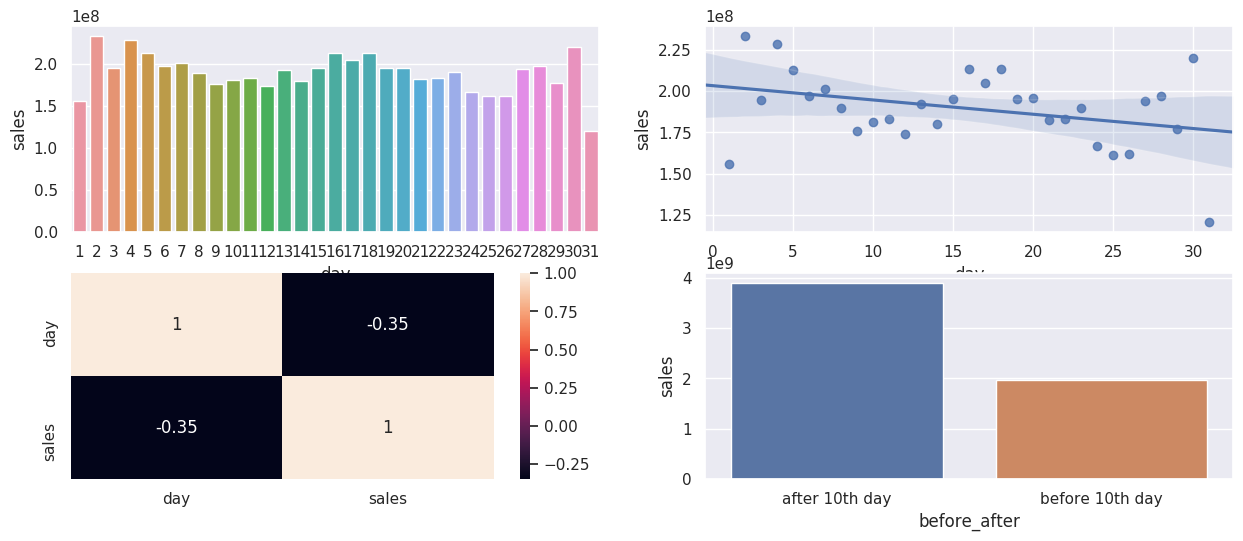

In [39]:
fig=plt.figure(figsize=(15,6), dpi= 100)

aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);
#plt.xticks(rotation = 90)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before 10th day' if x <= 10 else 'after 10th day')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### H11. Stores sell less during the weekends than on weekdays

**True**.

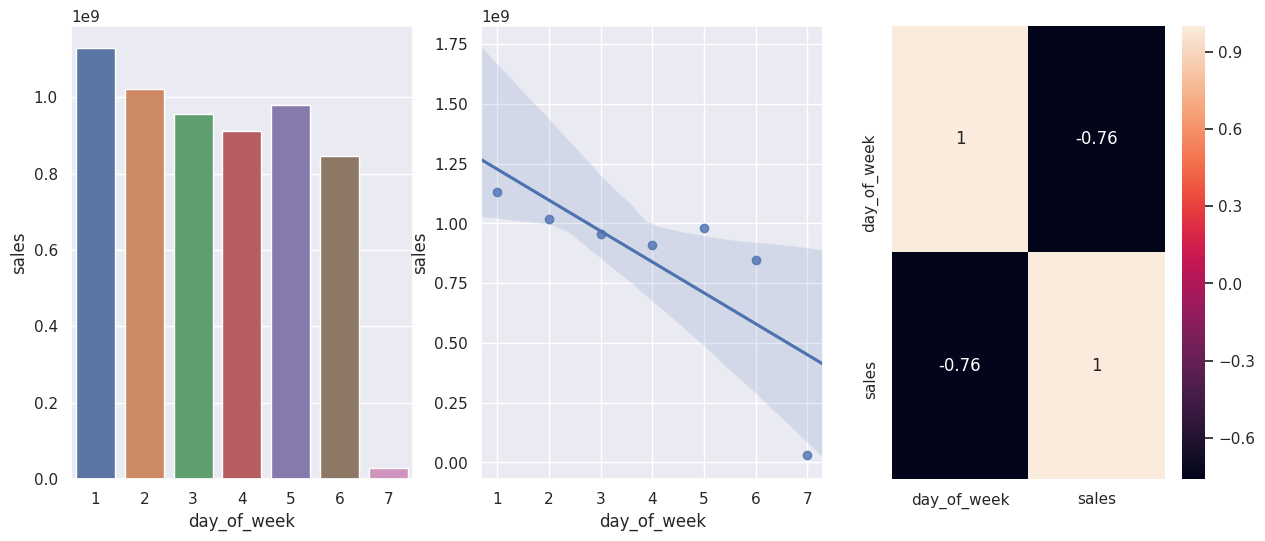

In [40]:
fig=plt.figure(figsize=(15,6), dpi= 100)

plt.subplot(1,3,1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Stores sell less during the scholar holidays

**True**, except for July and August

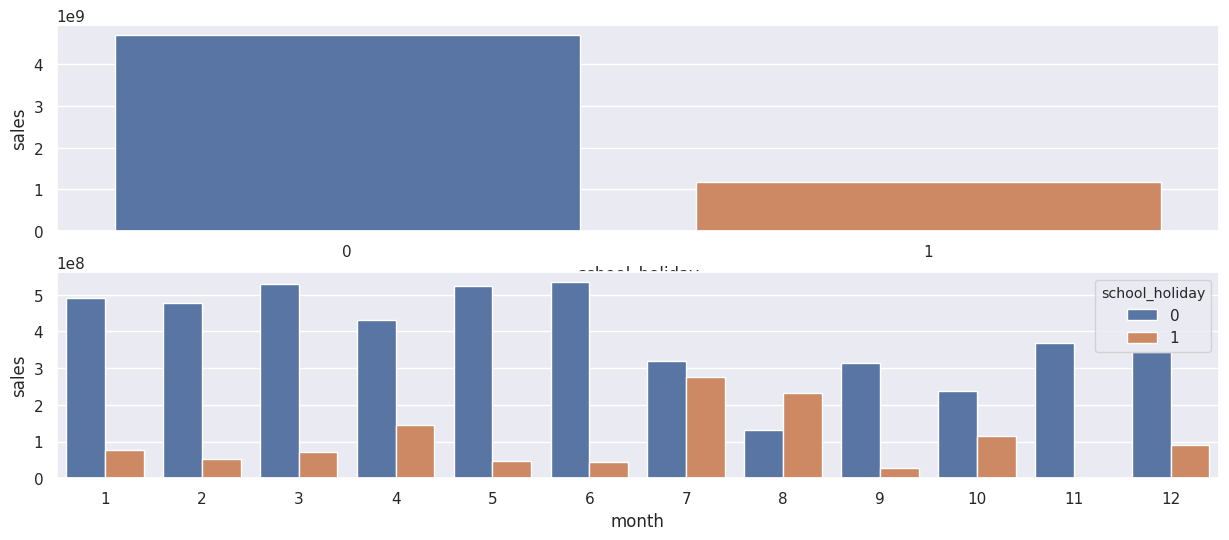

In [41]:
fig=plt.figure(figsize=(15,6), dpi= 100)

plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['school_holiday','month']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);


### 4.2.1 Summary

In [42]:
tab =[['Hypothesis','Conclusion','Relevance'],
      ['H1','False','Low'],
      ['H2','False','Medium'],
      ['H3','False','Medium'],
      ['H4','False','Low'],
      ['H5','-','-'],
      ['H6','False','Low'],
      ['H7','False','Medium'],
      ['H8','False','High'],
      ['H9','False','High'],
      ['H10','True','High'],
      ['H11','True','High'],
      ['H12','True','Low']]

print(tabulate(tab, headers = 'firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3 Multivariate analysis

### 4.3.1 Numerical Attributes

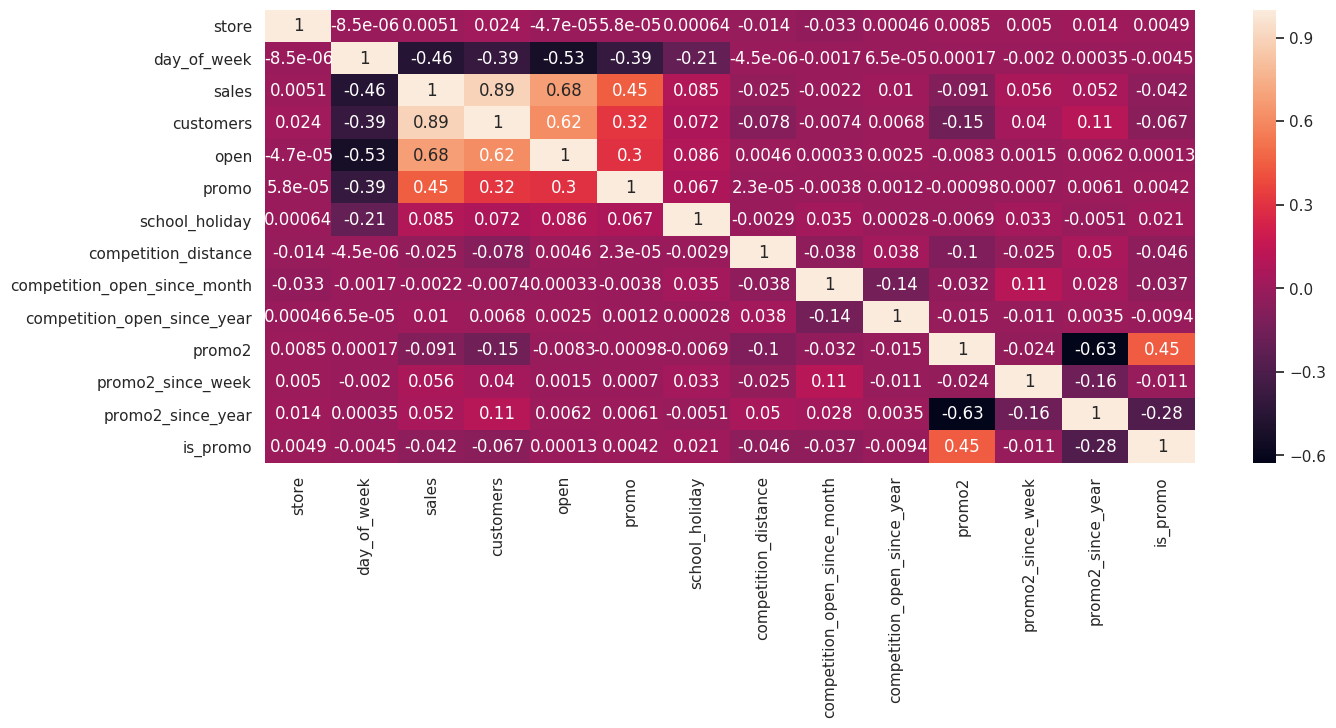

In [43]:
fig=plt.figure(figsize=(15,6), dpi= 100)

correlation = numerical_attributes.corr(method='pearson')
sns.heatmap(correlation, annot = True);

### 4.3.2 Categorical Attributes

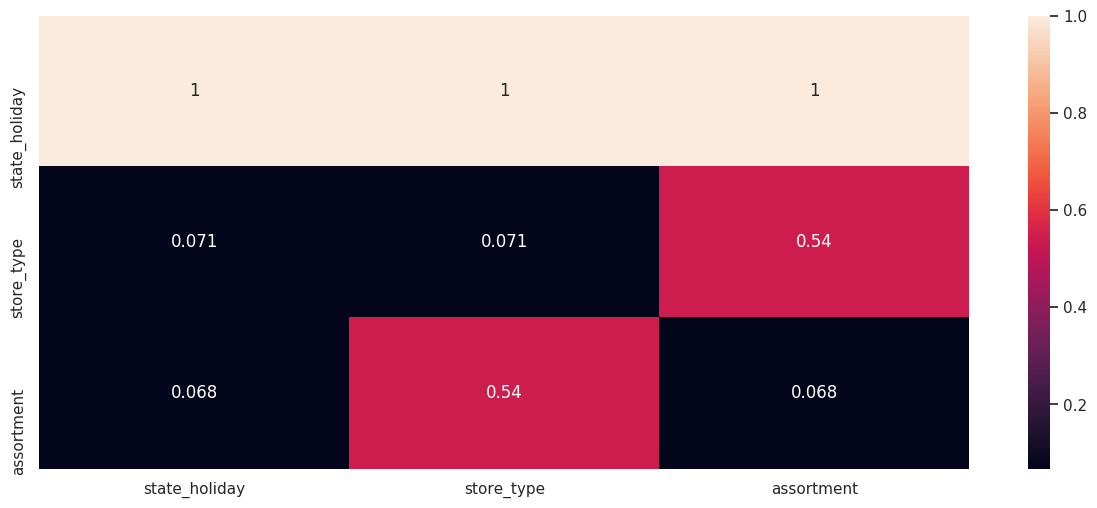

In [44]:
a = df4.select_dtypes(include='object')

# Calculate Cramer's V
a1 = cramer_v(x = a['state_holiday'], y = a['state_holiday'])
a2 = cramer_v(x = a['state_holiday'], y = a['store_type'])
a3 = cramer_v(x = a['state_holiday'], y = a['assortment'])

a4 = cramer_v(x = a['store_type'], y = a['store_type'])
a5 = cramer_v(x = a['store_type'], y = a['state_holiday'])
a6 = cramer_v(x = a['store_type'], y = a['assortment'])

a7 = cramer_v(x = a['assortment'], y = a['assortment'])
a8 = cramer_v(x = a['assortment'], y = a['store_type'])
a9 = cramer_v(x = a['assortment'], y = a['state_holiday'])

# Final Dataset
d = pd.DataFrame({'state_holiday':[a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)

fig=plt.figure(figsize=(15,6), dpi= 100)
sns.heatmap(d, annot=True);

# 5.0 DATA PREPARATION

In [45]:
df5 = df4.copy()

## 5.1 Normalization

## 5.2 Rescale

In [46]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformation

### 5.3.1 Encoding

In [47]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2 ,'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation


In [48]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3..3 Nature Transformation

In [49]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))  
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))  
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))  
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))  
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

# 6.0 FEATURE SELECTION

In [50]:
df6 = df5.copy()

## 6.1 Spliting Dataframe into training and test sets

In [51]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week','promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [52]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*6)

Timestamp('2015-06-19 00:00:00')

In [53]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# Testing Dataset 
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Traing min date: {}'.format(X_train['date'].min()))
print('Traing max date: {}'.format(X_train['date'].max()))

print('\nTest min date: {}'.format(X_test['date'].min()))
print('Test max date: {}'.format(X_test['date'].max()))

Traing min date: 2013-01-01 00:00:00
Traing max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selection

In [54]:
## training and testing datasets for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#Y_train_n = Y_train.values.ravel()
#
#
##Define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)
#
## Define Boruta
#BorutaPy(rf, n_estimators='auto', verbose = 2, random_state = 42).fit(X_train_n, Y_train_n)

### 6.2.1. Best Features from Boruta

In [55]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )



## 6.3. Manual Features Selection

In [56]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
features_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( features_to_add )